- Figure 4e
- Figure 4f
- changed to decoupler (old version?)

In [ ]:
import os
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

import scanpy as sc
import numpy as np
import pandas as pd
import decoupler as dc

import mplscience
import matplotlib.pyplot as plt

from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

seed = 777

In [51]:
# create pseudobulk & replicates
# condition : columns in adata.obs

def do_pseudobulk(adata, condition, contrast = None, seed = seed):
    print("*** Don't forget to set reference value for each category ***\n")
    
    
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) # 2-3 pseudo-replicates per each
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            if contrast:
                if pd.api.types.is_numeric_dtype(sample_cell_subset.obs[contrast]):
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].mean()
                else:
                    rep_adata.obs[contrast] = sample_cell_subset.obs[contrast].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    design_factors = [x for x in [contrast, 'condition', ] if x is not None]
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = design_factors,
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return pb, dds, de, fig

In [13]:
mh_path = '/home/jiehoonk/mnt/annotations/GO/mh.all.v2023.2.Mm.symbols.gmt'

def gmt_to_decoupler(path):
    from itertools import chain, repeat
    pathways = {}
    
    with Path(path).open('r') as f:
        for line in f:
            name, _, *genes = line.strip().split('\t')
            pathways[name] = genes
    
    return pd.DataFrame.from_records(chain.from_iterable(zip(repeat(k), v) for k, v in pathways.items()), columns=['geneset', 'genesymbol'])

hm = gmt_to_decoupler(mh_path)
hm.loc[:, 'geneset'] = [name.split('HALLMARK_')[1] for name in hm.geneset]
hm

,geneset,genesymbol
0,ADIPOGENESIS,Abca1
1,ADIPOGENESIS,Abcb8
2,ADIPOGENESIS,Acaa2
3,ADIPOGENESIS,Acadl
4,ADIPOGENESIS,Acadm
...,...,...
7184,XENOBIOTIC_METABOLISM,Upb1
7185,XENOBIOTIC_METABOLISM,Upp1
7186,XENOBIOTIC_METABOLISM,Vnn1
7187,XENOBIOTIC_METABOLISM,Vtn


# 1. Fig 4e

In [45]:
adata = sc.read_h5ad('../output/annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'] == 'OPC'].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 14204 × 9829
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [46]:
adata.obs['condition'] = adata.obs['sample_id'].apply(lambda x: 'Tumor' if x.startswith('Mouse') else 'Normal')

In [48]:
adata.obs.condition = adata.obs.condition.astype('category')

*** Don't forget to set reference value for each category ***



Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.47 seconds.

Fitting dispersion trend curve...
... done in 0.11 seconds.

Fitting MAP dispersions...
... done in 0.49 seconds.

Fitting LFCs...
... done in 0.30 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 14 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Tumor vs Normal
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik    70.741593        0.304765  0.198128  1.538223  1.239941e-01   
0610010K14Rik    86.750912        0.714388  0.192151  3.717849  2.009266e-04   
0610030E20Rik    39.725629        0.225517  0.081267  2.775000  5.520168e-03   
0610040J01Rik   215.201632       -1.385805  0.165116 -8.392917  4.742280e-17   
1110002L01Rik    19.285662        0.038860  0.132865  0.292481  7.699188e-01   
...                    ...             ...       ...       ...           ...   
mt-Nd3          516.205002       -1.159673  0.296547 -3.910592  9.207004e-05   
mt-Nd4         2893.283179       -0.446573  0.201798 -2.212968  2.689984e-02   
mt-Nd4l         245.533579       -1.659588  0.211144 -7.859997  3.841424e-15   
mt-Nd5          336.994769       -0.432704  0.111710 -3.873461  1.073005e-04   
mt-Nd6           51.012496       -0.026039  0.182234 -0.

... done in 0.29 seconds.



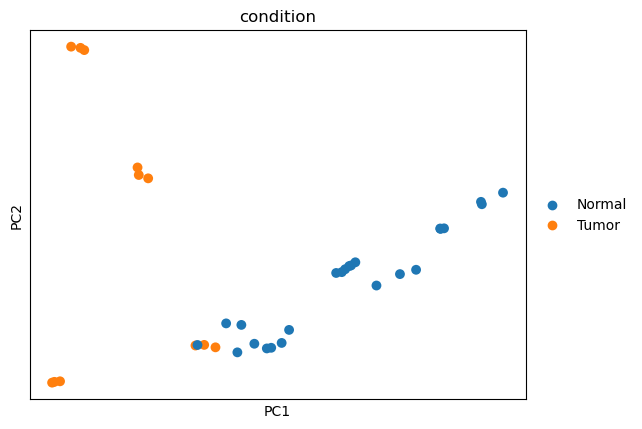

In [54]:
pb, dds, de, fig = do_pseudobulk(adata, 'condition')

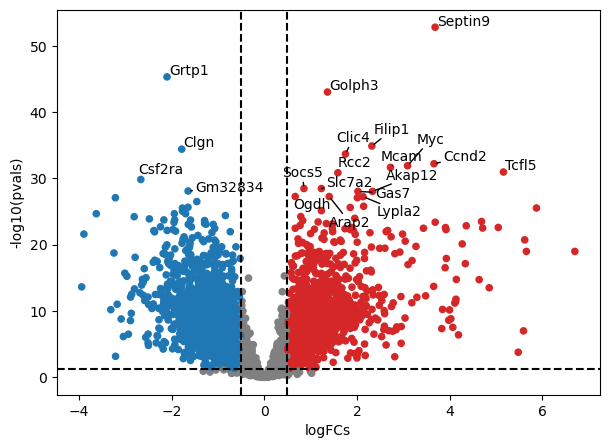

In [57]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

In [73]:
top_genes = de[de['padj'] < 0.05]

enriched = dc.get_ora_df(df = top_genes, net = hm, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.490000,6.913611e-07,0.000003,1.525512,21.638784,Abca1;Abcb8;Acadl;Acadm;Acly;Aco2;Acox1;Adipor...
1,ALLOGRAFT_REJECTION,192,0.244792,9.933962e-01,0.999905,0.760453,0.005039,Abce1;Ache;Akt1;Apbb1;B2m;Bcat1;Bcl10;Ccnd2;Cc...
2,ANDROGEN_RESPONSE,96,0.541667,8.127247e-06,0.000031,1.686084,19.761388,Abhd2;Acsl3;Adamts1;Akap12;Akt1;Ank;Appbp2;Ari...
3,ANGIOGENESIS,36,0.166667,9.896876e-01,0.999905,0.549636,0.005698,App;Ccnd2;Lrpap1;Pdgfa;Vcan;Vegfa
4,APICAL_JUNCTION,199,0.386935,3.425345e-02,0.065872,1.202393,4.056837,Actg1;Actn4;Adam15;Adam23;Adamts5;Akt2;Arhgef6...


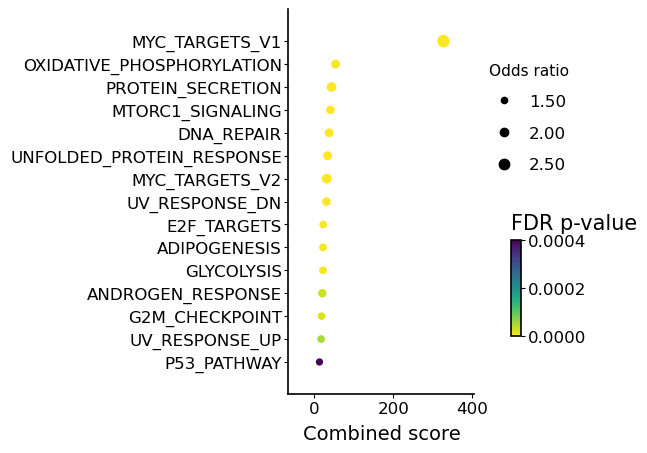

In [92]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
    )
    plt.grid(False)


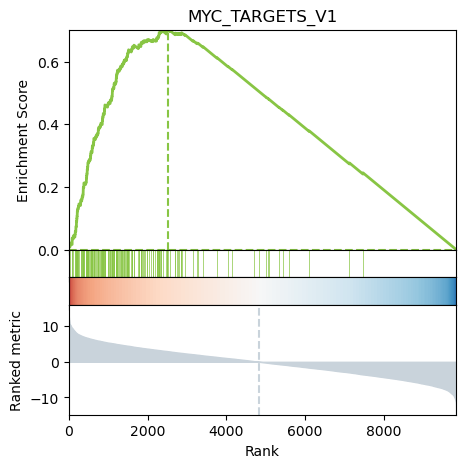

In [76]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=hm,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

# 2. Fig 4f

In [38]:
def do_pseudobulk(adata, condition, reference, seed = 123):
    pseudobulk = []
    random.seed(seed)
    for sample in adata.obs.sample_id.unique():
        sample_cell_subset = adata[adata.obs['sample_id'] == sample]
        
        idx = list(sample_cell_subset.obs_names)
        random.shuffle(idx)
        idx = np.array_split(np.array(idx), 3) 
        
        for i, pr in enumerate(idx):
            rep_adata = sc.AnnData(X = sample_cell_subset[idx[i]].X.sum(axis = 0).reshape(1,-1),
                                   var = sample_cell_subset[idx[i]].var[[]])
            rep_adata.obs_names = [sample + "-" + str(i)]

            rep_adata.obs['condition'] = sample_cell_subset.obs[condition].iloc[0]
            rep_adata.obs['replicate'] = i
            pseudobulk.append(rep_adata)
    pb = sc.concat(pseudobulk)
    
    counts_df = pd.DataFrame(pb.X, columns=pb.var_names)
    inference = DefaultInference()
    
    dds = DeseqDataSet(
        counts = counts_df,
        metadata = pb.obs,
        design_factors = ['condition'],
        ref_level=['condition' ,reference],
        refit_cooks= True,
        inference = inference,
        n_cpus=None
    )
    sc.pp.filter_genes(dds, min_cells=1)
    dds.deseq2()
    sc.tl.pca(dds, layer="normed_counts")
    fig = sc.pl.pca(dds, color = 'condition', size = 200, show=False)
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    de = stat_res.results_df
    
    return dds, de, fig

In [70]:
adata = sc.read_h5ad('../output/8_annotated_subcluster_embedding.h5ad')
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor'])].copy()
adata = adata[adata.obs['cell_type'].isin(['OPC', 'Tumor']) & adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4', 'Control'])].copy()
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.1))
adata

AnnData object with n_obs × n_vars = 17722 × 10588
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'cell_type_colors', 'each_cell_type_colors', 'neighbors', 'sample_id_colors', 'sample_info_colors', 'umap'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [72]:
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()
adata.obs.cell_type = adata.obs.cell_type.cat.reorder_categories(['OPC', 'Tumor'])

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.04 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 2.80 seconds.

Fitting LFCs...
... done in 3.46 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.41 seconds.



Log2 fold change & Wald test p-value: condition Tumor vs OPC
                  baseMean  log2FoldChange     lfcSE      stat        pvalue  \
0610009B22Rik   254.245543       -0.220174  0.267735 -0.822358  4.108730e-01   
0610010K14Rik   353.005829        0.186626  0.164486  1.134599  2.565432e-01   
0610030E20Rik   128.595103       -0.104747  0.144641 -0.724188  4.689505e-01   
0610040J01Rik   372.322553       -1.098238  0.196382 -5.592345  2.240233e-08   
1110002L01Rik    69.840354        0.043591  0.151669  0.287407  7.738009e-01   
...                    ...             ...       ...       ...           ...   
mt-Nd3          886.851751       -0.073951  0.149873 -0.493422  6.217143e-01   
mt-Nd4         7115.503993        0.276950  0.154725  1.789953  7.346142e-02   
mt-Nd4l         326.957917       -0.537463  0.286904 -1.873322  6.102398e-02   
mt-Nd5          815.288932        0.050913  0.154161  0.330258  7.412050e-01   
mt-Nd6          136.237947       -0.466263  0.304363 -1.531

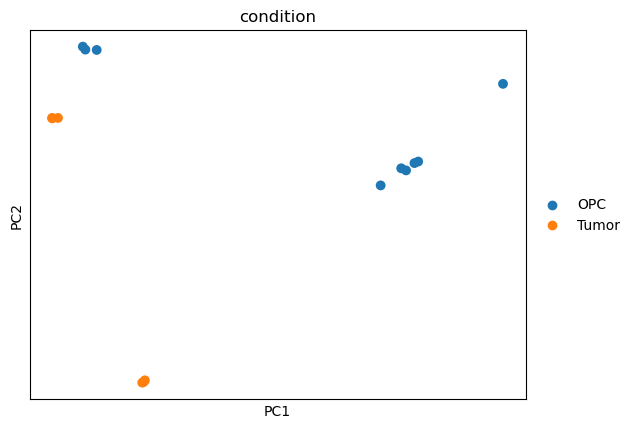

In [73]:
dds, de, fig = do_pseudobulk(adata, 'cell_type', 'OPC')

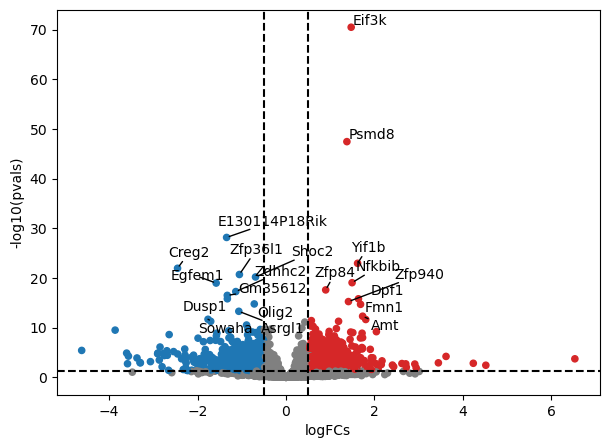

In [75]:
dc.plot_volcano_df(de, x='log2FoldChange', y='padj', top = 20)

In [76]:
top_genes = de[de['padj'] < 0.05]

enriched = dc.get_ora_df(df = top_genes, net = hm, source = 'geneset', target = 'genesymbol')
enriched.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features
0,ADIPOGENESIS,200,0.205000,0.000073,0.000396,1.881275,17.924412,Acox1;Ak2;Aplp2;Apoe;Bcl6;Cd302;Chuk;Cs;Cyc1;D...
1,ALLOGRAFT_REJECTION,192,0.130208,0.226062,0.325796,1.195709,1.777953,Aars;B2m;Bcat1;Bcl3;Cd47;Csk;Degs1;Eif3d;Eif3j...
2,ANDROGEN_RESPONSE,96,0.218750,0.001692,0.005182,2.017140,12.872809,Abcc4;Abhd2;Adrm1;Arid5b;B2m;Camkk2;Dnajb9;Ell...
3,ANGIOGENESIS,36,0.055556,0.920546,0.980582,0.616655,0.051052,Vcan;Vegfa
4,APICAL_JUNCTION,199,0.160804,0.020087,0.039021,1.474655,5.762454,Actb;Actn4;Adam23;Bmp1;Cadm3;Cap1;Cd276;Cldn11...


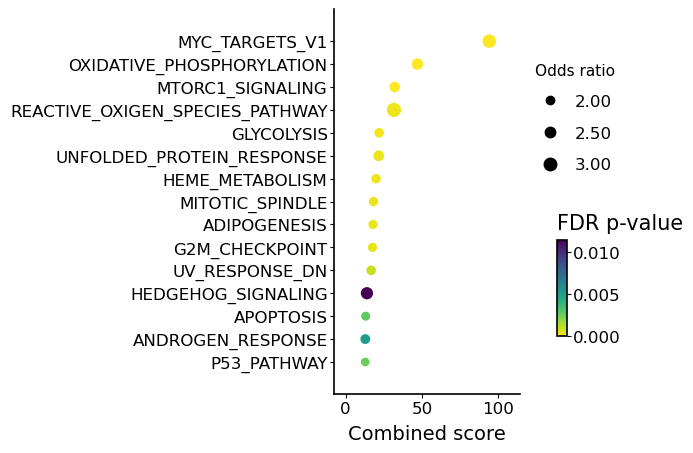

In [77]:
with mplscience.style_context():
    dc.plot_dotplot(
        enriched.sort_values('Combined score', ascending=False).head(15),
        x='Combined score',
        y='Term',
        s='Odds ratio',
        c='FDR p-value',
        scale=0.5,
    )
    plt.grid(False)


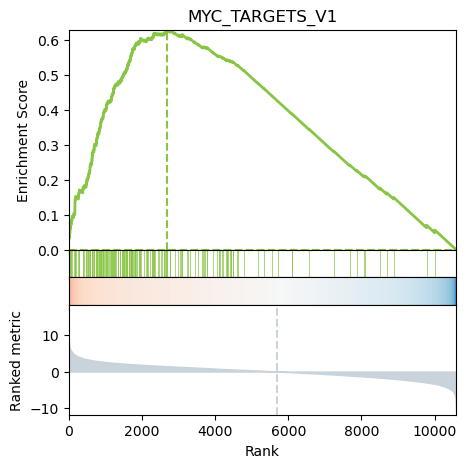

In [78]:
dc.plot_running_score(
    df=de,
    stat='stat',
    net=hm,
    source='geneset',
    target='genesymbol',
    set_name='MYC_TARGETS_V1'
)

- old method

In [102]:
geneset_size = hm.groupby('geneset').size()
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]

t_stats = sigs[['stat']].copy()
t_stats.rename(columns = {'stat': 'scores'}, inplace = True)

scores, norm, pvals = dc.run_gsea(t_stats.T, hm[hm.geneset.isin(gsea_genesets)], source = 'geneset', target='genesymbol', seed = seed, times = 100000, min_n = 15)

gsea_results = pd.concat({"score" : scores.T, "norm" : norm.T, "pval" : pvals.T}, axis = 1).droplevel(1, axis = 1).sort_values('pval')
epsilon = np.finfo(float).tiny  # Or use 1e-308
gsea_results['-log10(pval)'] = -np.log10(gsea_results.pval + epsilon)

In [104]:
pvals.T.sort_values(by='scores')

,scores
source,
G2M_CHECKPOINT,0.000000
E2F_TARGETS,0.000000
MYC_TARGETS_V1,0.000000
MITOTIC_SPINDLE,0.000000
OXIDATIVE_PHOSPHORYLATION,0.000000
MTORC1_SIGNALING,0.000000
MYC_TARGETS_V2,0.000000
UNFOLDED_PROTEIN_RESPONSE,0.000000
INTERFERON_GAMMA_RESPONSE,0.000594


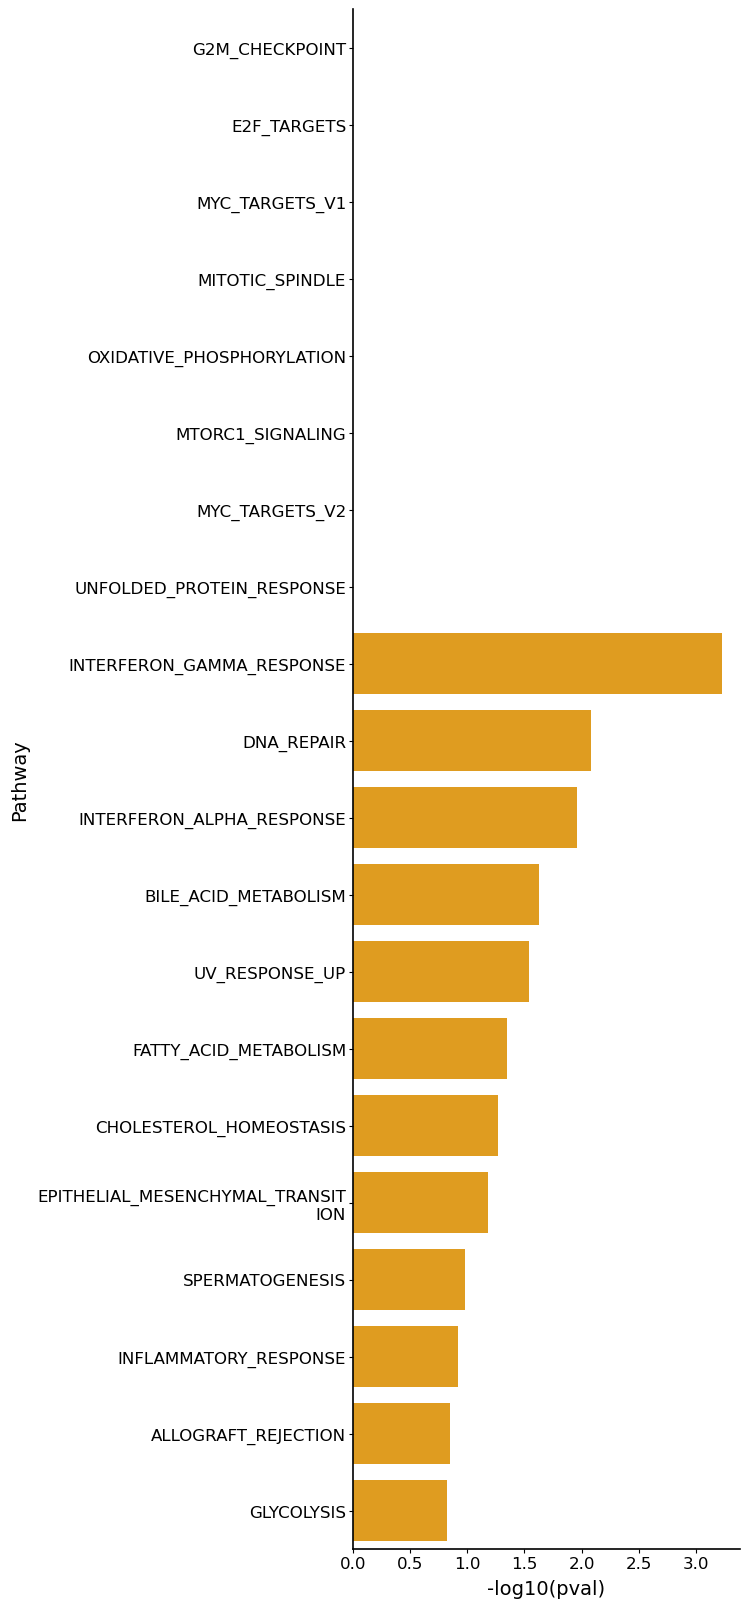

In [103]:
import textwrap

def wrap_labels(ax, width):
    labels = [textwrap.fill(label.get_text(), width) for label in ax.get_yticklabels()]
    ax.set_yticklabels(labels, rotation=0, ha='right')

with mplscience.style_context():
    plt.figure(figsize = (5, 20))
    ax = sns.barplot(gsea_results.head(20), x = '-log10(pval)', y = gsea_results.head(20).index, color = 'orange')
    wrap_labels(ax, 30)
    plt.xlabel('-log10(pval)')
    plt.ylabel('Pathway')
    plt.show()